In [5]:
import pandas as pd
import numpy as np
import os
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import train_test_split
# from transformers import AutoImageProcessor, ResNetForImageClassification,ResNetConfig
import torch
from abc import ABC,abstractmethod

In [6]:
#TODO check if layers are actually being trained
#TODO add more models
#TODO compare metrics
#TODO test out prediction loop
#TODO learn how to use tensorboard

#TODO week2 Balance Dataset
#TODO day2 Implement checkpointing and checkpoint loading
#TODO day2 implement an actually good and modular pipeline
#TODO day2 EDA + explore augments
#TODO day2 normalize and test out mean/median/std of pixel values
#TODO day2 Actually implement additional layers and finish what i started
#TODO Verify data is sent correctly (esp labels)

#TODO day2 implement localization/segmentation + research more abt osteopenia
#interesting models: yolo v5, medsam

###DATASET PREP###

In [7]:
projectPath = r"OsteoBinary"
pathList = []
labelList = []
dirList = os.listdir(projectPath)[:3]
for idx, x in enumerate(dirList):
    for xx in os.listdir(f"{projectPath}/{x}"):
        pathList.append(f"{projectPath}/{x}/{xx}")
        labelList.append(idx)

In [8]:
from PIL import Image
imageSizes = {}
for x in pathList:
    img = Image.open(x).size
    try:
        imageSizes[str(img)] = imageSizes[str(img)] + 1
    except KeyError:
        imageSizes[str(img)] = 1
imageSizes #varied image sizes, have to resize to 1024,1024

{'(525, 1024)': 1,
 '(1040, 2656)': 3,
 '(1056, 2656)': 2,
 '(1128, 2656)': 3,
 '(1036, 2660)': 2,
 '(952, 2656)': 2,
 '(558, 1024)': 1,
 '(528, 1024)': 1,
 '(553, 1024)': 1,
 '(1127, 2660)': 1,
 '(492, 998)': 2,
 '(1312, 2180)': 1,
 '(1088, 2656)': 4,
 '(1149, 2660)': 1,
 '(1096, 2656)': 4,
 '(1076, 2660)': 2,
 '(1032, 2656)': 3,
 '(1040, 2660)': 1,
 '(1144, 2656)': 1,
 '(1095, 2660)': 1,
 '(1113, 2660)': 2,
 '(1008, 2656)': 3,
 '(976, 1972)': 1,
 '(1280, 1896)': 1,
 '(1123, 2656)': 3,
 '(1124, 2660)': 2,
 '(1064, 2656)': 4,
 '(1088, 2280)': 1,
 '(2430, 1994)': 83,
 '(1994, 2430)': 2,
 '(1329, 2180)': 1,
 '(1344, 2520)': 1,
 '(1195, 2656)': 1,
 '(1096, 2659)': 1,
 '(1113, 2656)': 1,
 '(1131, 2656)': 2,
 '(1332, 2180)': 2,
 '(1107, 2656)': 1,
 '(1107, 2659)': 1,
 '(1387, 2179)': 1,
 '(1208, 2296)': 1,
 '(1147, 2656)': 2,
 '(1163, 2656)': 3,
 '(1099, 2656)': 2,
 '(1024, 2656)': 3,
 '(1016, 2656)': 1,
 '(1072, 2480)': 1,
 '(1139, 2659)': 1,
 '(1044, 2660)': 2,
 '(1357, 1992)': 2,
 '(1235

In [9]:
import torchvision
import torch
import torchvision.transforms.functional


class OsteoTorchDataset(torch.utils.data.Dataset):
    def __init__(self, itemsPath:list, labels:list, transform=None, std = False, mean = False): #mean on if mean needs to be scaled, same goes for std
        
        self.itemsPath = itemsPath
        self.labels = labels
        self.transform = transform
        self.std = std
        self.mean = mean

    def __len__(self):
        return len(self.itemsPath)

    def __getitem__(self,idx)->tuple[Image.Image,int]:
        # if torch.is_tensor(idx):
        #     idx = idx.tolist()
        image = Image.open(self.itemsPath[idx]).convert('RGB')
        # image = torchvision.transforms.functional.pil_to_tensor(image)

        if self.transform:
            image = self.transform(image)  
        
        image.to(device = torch.device('cuda'))

        if self.mean or self.std:
            image = self.scaler(image,self.mean,self.std)
        

        return image, self.labels[idx], self.itemsPath[idx]          
    
    def scaler(self,image:torch.tensor,normMean = False,normStd = False): #TODO better way to do this? also huge bottleneck without cuda
        imageSum = torch.sum(image,dim=(1,2))
        mean = imageSum/(image.shape[1]*image.shape[2])
        sum_squared_tensor = torch.sum((imageSum - mean)**2)
        std = torch.sqrt(sum_squared_tensor/image.shape[1]*image.shape[2])

        if not normMean:
            mean = torch.zeros_like(mean,device='cuda')

        if not normStd:
            std = torch.ones_like(std,device='cuda')

        image = torchvision.transforms.functional.normalize(image.float(),mean,std)
        return image
        


transform = torchvision.transforms.Compose([
                                            torchvision.transforms.Resize([244,244]),
                                            torchvision.transforms.ToTensor()
                                            # ,torchvision.transforms.Grayscale()
                                            ])
osteoDataset = OsteoTorchDataset(pathList,labelList,transform,std=True,mean=True)                                  


In [10]:
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import WeightedRandomSampler

osteoDataset = OsteoTorchDataset(pathList,labelList,transform,std=False,mean=False)      
train,val = torch.utils.data.random_split(osteoDataset,[0.8,0.2])#MAY BUG
trainLabels = [y for x,y,z in train]
unique_elements, counts = torch.unique(torch.tensor(trainLabels), return_counts=True)
sampleWeights = 1. / counts.float() #I HAVE NO IDEA WHY THIS WORKS BUT IT DOES
# MORAL OF THE STORY: FOLLOW THE FUCKING TUTORIAL DONT TRY CHANGING SHIT ON YOUR OWN ***EVEN IF THE DOCUMENTATION SAYS YOU SHOULD***
trainSampler = WeightedRandomSampler(weights=[sampleWeights[x] for x in trainLabels],num_samples=len(train),replacement=True)

trainLoader = DataLoader(train, batch_size = 8,shuffle=False,num_workers=0,sampler=trainSampler)
valLoader = DataLoader(val, batch_size = 8,shuffle=False,num_workers=0)

unique_elements, counts = torch.unique(torch.cat([x for y,x,z in trainLoader]), return_counts=True)#delet this
counts

tensor([141, 157])

In [11]:
unique_elements, counts = torch.unique(torch.cat([x for y,x,z in valLoader]), return_counts=True)#delet this
counts

tensor([38, 36])

In [12]:
temp = next(iter(trainLoader))

tensor(1) OsteoBinary/osteoporosis/18.png
torch.Size([3, 244, 244])


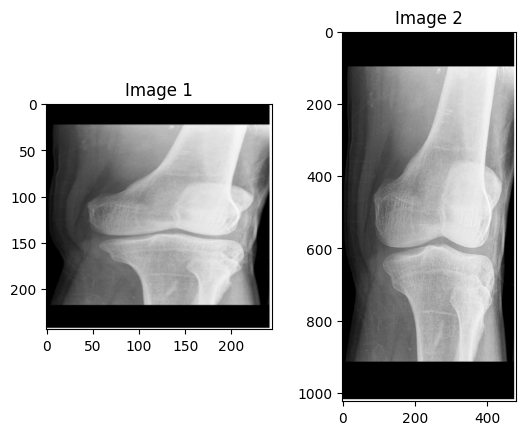

In [13]:
# temp[0][0].min()
import matplotlib.pyplot as plt
index = 0
print(temp[1][index],temp[2][index])
print(temp[0][index].shape)

fig, axs = plt.subplots(1, 2)

# Plot the first image
axs[0].imshow(temp[0][index].permute(1, 2, 0))
axs[0].set_title('Image 1')

# Plot the second image
axs[1].imshow(Image.open(temp[2][index]).convert('RGB'))
axs[1].set_title('Image 2')

plt.show()

In [20]:
# import models here
from models import AlexNet,resnetWrapper
from resnetModel import ResNet50
import lightning as L
from lightning.pytorch.callbacks import ModelCheckpoint
from torcheval.metrics.functional import multiclass_f1_score,multiclass_confusion_matrix,multiclass_accuracy
from torchmetrics.classification import MulticlassConfusionMatrix
from matplotlib import pyplot as plt
from torch import mode
import torch.nn.functional as F
import itertools
import seaborn as sns

#FIXME identify bottleneck
#FIXME clean up my fucking code ffs its so UGLY

class ExperimentModel(L.LightningModule):

    existingModels = []

    def __init__(self,pretrainedModel,resize = False,num_class = 3,outputSize = 1000,pretrained = False) -> None:
        ExperimentModel.existingModels.append(self)
        super().__init__()
        if type(pretrainedModel) != str:
            print("using model as-is")
            self.model = pretrainedModel
        else:
            self.model = torch.hub.load('pytorch/vision:v0.19.0', pretrainedModel, pretrained=pretrained)
            
            
        # if pretrainedPreprocess:
        #     self.preprocess = pretrainedPreprocess  
        # for param in self.model.parameters():
        #     param.requires_grad = False
        self.resize = resize

        if self.resize:
            linear1 = None
            try: 
                linear1 = torch.nn.Linear(self.model.fc.out_features, 256)
            except AttributeError:
                print("no fc detected, switcing to provided outputSize")
                linear1 = torch.nn.Linear(outputSize, 256)
            self.customHead = torch.nn.Sequential(linear1,torch.nn.ReLU(),torch.nn.Linear(256,num_class))

        self.num_class = num_class
        self.criterion = torch.nn.CrossEntropyLoss()

        # self.resize = resize
        # if self.resize:
        #     self.linear1 = torch.nn.Linear(1000,256)
        #     self.relu1= torch.nn.ReLU()
        #     self.linear2 = torch.nn.Linear(256,3)

        self.valLog = []
        self.epoch = []
        self.valPreds = []
        self.valLabels = []
        self.valScore = []

        self.bestValPreds = [[]]
        self.bestValLabels = [[]]
        self.bestValScore = []

        self.dump = []
        
    def forward(self,input):
        out = self.model(input)
        if self.resize:
            out = self.customHead(out)
        return out
        
    def training_step(self,batch):
        data,label,path = batch

        output = self(data)
        # print('\n train pred vs label')
        # print(output.argmax(1))
        # print(data[0])
        # print(label[0])
        self.dump.append([path,label])
        loss = self.criterion(output,label)
        # print(loss)
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx) -> None:
        data,label,path = batch
        output = self(data)

        preds = output.argmax(1)
        f1 = multiclass_f1_score(preds,label,num_classes=self.num_class,average = 'macro')
        # print('\npred vs label')
        # print(preds)
        # print(label)
        # print(f'f1:{f1}')
        loss = F.cross_entropy(output,label)
        self.valLabels.append(label)
        self.valPreds.append(output)
        self.valScore.append(multiclass_f1_score(preds,label,num_classes=self.num_class,average = 'macro'))
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log("val_acc_F1", multiclass_f1_score(preds,label,num_classes=self.num_class,average = 'macro'), on_step=False, on_epoch=True, prog_bar=True, logger=True,)
        self.log("val_acc", multiclass_accuracy(preds,label,num_classes=self.num_class), on_step=False, on_epoch=True, prog_bar=True, logger=True)

    
    def on_validation_epoch_end(self) -> None:
        if len(self.valScore) == 2:
            return None
        
        accuracy = torch.stack(self.valScore).mean()
        self.bestValScore.append(accuracy)
        self.bestValPreds.append(torch.cat(self.valPreds))
        self.bestValLabels.append(torch.cat(self.valLabels))

        # print(f"\n Validation accuracy: {accuracy}")
        # print(f"bestValScore: {self.bestValScore}")
        
        self.valPreds = []
        self.valLabels = []
        self.valScore = []
        

    def configure_optimizers(self):
        return torch.optim.Adagrad(self.parameters(), lr=0.005)

    def predict_step(self, batch):
        data,label = batch
        return self(data.float())

# class ResNetCallbacks(L.Callback): #TODO implement callbacks
#     def on_validation_epoch_end(trainer, pl_module):
#         valLog.append(sum(self.cumLog)/len(self.cumlog))

# alexNet = ExperimentAlexNet(AlexNet(num_classes=3))
# resNet = ExperimentAlexNet(ResNet50(num_classes=3))
# preResNet = ExperimentModel(ResNet50(num_classes=2),num_class=2)
resnet50 = ExperimentModel("resnet50",resize=True,pretrained=True,num_class=2)
vgg19 = ExperimentModel("vgg19",resize=True,pretrained=True,num_class=2)
# effnet = ExperimentModel("efficientnet_v2_m",resize=True,pretrained=True,num_class=2)
# mobilenet = ExperimentModel("mobilenet_v3_large",resize=True,pretrained=True,num_class=2)

Using cache found in C:\Users\assaw/.cache\torch\hub\pytorch_vision_v0.19.0
C:\Users\assaw\AppData\Roaming\Python\Python310\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\assaw\AppData\Roaming\Python\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Using cache found in C:\Users\assaw/.cache\torch\hub\pytorch_vision_v0.19.0
C:\Users\assaw\AppData\Roaming\Python\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecate

no fc detected, switcing to provided outputSize


In [21]:
ExperimentModel.existingModels[0].model.__class__.__name__

'ResNet'

In [16]:
# import re
# labelProcess = [re.search(r'\/.*\/',x)[0] for x in preResNet.dump[0][0]]
# [x.strip('\/') for x in labelProcess]

In [22]:
import gc
gc.collect()
torch.cuda.empty_cache()

from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping
from lightning.pytorch.loggers import TensorBoardLogger
for x in ExperimentModel.existingModels:
    gc.collect()
    torch.cuda.empty_cache()
    early_stopping = EarlyStopping(
        monitor='val_loss',  # Metric to monitor
        patience=5000,          # Number of epochs with no improvement after which training will be stopped
        verbose=False,        # Verbosity mode
        mode='min'           # Mode can be 'min', 'max', or 'auto'
    )

    logger = TensorBoardLogger("tb_logs", name=f"{x.model.__class__.__name__}")


    trainer = L.Trainer(max_epochs = 75,accelerator='gpu', devices='auto', precision='16-mixed',logger=logger)
    trainer.fit(model=x,train_dataloaders=trainLoader,val_dataloaders=valLoader)


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type             | Params | Mode 
--------------------------------------------------------
0 | model      | ResNet           | 25.6 M | train
1 | customHead | Sequential       | 256 K  | train
2 | criterion  | CrossEntropyLoss | 0      | train
--------------------------------------------------------
25.8 M    Trainable params
0         Non-trainable params
25.8 M    Total params
103.255   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=75` reached.
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type             | Params | Mode 
--------------------------------------------------------
0 | model      | VGG              | 143 M  | train
1 | customHead | Sequential       | 256 K  | train
2 | criterion  | CrossEntropyLoss | 0      | train
--------------------------------------------------------
143 M     Trainable params
0         Non-trainable params
143 M     Total params
575.696   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=75` reached.


In [18]:
ExperimentModel.existingModels[2].model.__class__.__name__

IndexError: list index out of range

In [ ]:
for x in valLoader:
    data, label, _ = x
    print(preResNet(data.to(torch.device('cuda'))))
# preResNet()

In [ ]:
# raise AssertionError("done")
x = preResNet
print(f"model: {x.model.__class__.__name__}")
print(f"bestValScore: {max([y.item() for y in x.bestValScore])}")
print(f"bestValPreds: {[[y.argmax().item() for y in w] for w in x.bestValPreds]}")
    # print(f"bestValLabels: {x.bestValLabels}")

In [ ]:
# x.bestValLabels[1].cpu()
[[y.argmax().item() for y in w] for w in x.bestValPreds][1]

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# [[y.argmax().item() for y in w] for w in x.bestValPreds]
# ([1, 2, 0, 1, 2, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 0, 0, 2, 1,
#          1, 1, 1, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
# [[y.argmax().item() for y in w] for w in x.bestValPreds]
index = 50
cm = confusion_matrix([[y.argmax().item() for y in w] for w in x.bestValPreds][index], x.bestValLabels[1].cpu())
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
# plt.plot(confusion_matrix([[y.argmax().item() for y in w] for w in x.bestValPreds][index],x.bestValLabels[1].cpu()))
print(classification_report([[y.argmax().item() for y in w] for w in x.bestValPreds][index],x.bestValLabels[1].cpu()))


In [ ]:
for x in [[y.argmax().item() for y in w] for w in x.bestValPreds]:
    print(x)

In [ ]:
evalPred = torch.tensor([[y.argmax().item() for y in w] for w in x.bestValPreds][2]).to('cuda:0')
evalPred

In [ ]:
multiclass_f1_score(evalPred,evalLabels,num_classes=3,average='macro')

In [ ]:
import sklearn
sklearn.metrics.f1_score(evalLabels.cpu(),evalPred.cpu(),average='macro')

In [ ]:
# raise AssertionError("Stop here")
# alex net acc F1 = 0.62 loss = 0.923
# resnet18 acc F1 = ? loss = 1
# resnet50 acc F1 = 0.29 loss = 3
# resnet50 Custom acc F1 = 0.62 loss = 0.957
# resnet50 Custom acc oversampled F1 = 0.78 loss = 0.759
# mobilenet 
# effnet
# Vits 

# model = alexNetNonMod.load_from_checkpoint("/path/to/checkpoint.ckpt")


def testConfMatrix(self) -> None:
        y_hat = torch.tensor([y.argmax() for y in self.bestValPreds]).to('cpu')
        y = self.bestValLabels.to('cpu')

        print(y_hat),print(y)

        confusion_matrix = MulticlassConfusionMatrix(num_classes=3,normalize='true')
        print(confusion_matrix(y_hat, y))

        confusion_matrix_computed = confusion_matrix.compute().detach().cpu().numpy()

        df_cm = pd.DataFrame(confusion_matrix_computed)
        plt.figure(figsize = (10,7))
        fig_ = sns.heatmap(df_cm, annot=True, cmap='Spectral',fmt='g').get_figure()
        plt.show()
       

testConfMatrix(modelList[3])

# early_stopping = EarlyStopping(
#     monitor='val_loss',  # Metric to monitor
#     patience=3,          # Number of epochs with no improvement after which training will be stopped
#     verbose=True,        # Verbosity mode
#     mode='min'           # Mode can be 'min', 'max', or 'auto'
# )

# logger = TensorBoardLogger("tb_logs", name="my_model")
# trainer = L.Trainer(max_epochs = 20,accelerator='gpu', devices='auto', precision='16-mixed',callbacks=[early_stopping],logger=logger)
# trainer.fit(model=alexNetNonMod,train_dataloaders=trainLoader,val_dataloaders=valLoader

In [ ]:
data = []
label = []
valOutput = []
valLabel = []

from itertools import tee
testTrainer =  L.Trainer(accelerator='gpu', devices='auto')
out = testTrainer.predict(alexNet, valLoader)

loader1, loader2 = tee(valLoader) #BUG BUG BUG INCREDIBLY MEMORY INEFFICIENT DONOT RUN THIS ON ANYTHIGN BIGGER THAN 1000 IMAGES

for idx,x in enumerate(valLoader):
    data,label = x
    [valLabel.append(x) for x in label]

valOutput = trainer.predict(alexNet, loader2)

In [ ]:
from resnetModel import ResNet50
model = ResNet50(num_classes=2)

In [ ]:
# from transformers import ViTImageProcessor, ViTForImageClassification
from PIL import Image
# model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')


In [ ]:
from torchvision.models import vgg19


In [ ]:
import torch

import torch.nn as nn
import torch.optim as optim
torch.cuda.empty_cache()
# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Set the device to GPU if available
device = torch.device("cuda")

# Move the model to the device
model = model.to(device)

# Set the model to training mode
model.train()

num_epochs = 50

accHistory = []
lossHistory = []
valAccHistory = []

print("Starting training...")

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_accuracy = []
    
    # Iterate over the training dataset
    for inputs, labels, _ in trainLoader:
        # Move the inputs and labels to the device
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        predicted_labels = torch.argmax(outputs, dim=1)
        accuracy = torch.sum(predicted_labels == labels).item() / labels.size(0)
        running_accuracy.append(accuracy)
        # Compute the loss
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        
        # Update the weights
        optimizer.step()
        
        # Update the running loss
        running_loss += loss.item()
    
    # Print the average loss for the epoch
    print(f"Epoch {epoch+1} - Loss: {running_loss / len(trainLoader)}")
    print(F"Accuracy: {sum(running_accuracy)/len(running_accuracy)}")
    accHistory.append(sum(running_accuracy)/len(running_accuracy))
    lossHistory.append(running_loss / len(trainLoader))

    # Set the model to evaluation mode
    model.eval()

    # Disable gradient calculation
    with torch.no_grad():
        for inputs, labels, _ in valLoader:

            # Move the inputs and labels to the device
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(inputs)

            # Compute the loss
            loss = criterion(outputs, labels)

            # Compute the predicted labels
            predicted_labels = torch.argmax(outputs, dim=1)

            # Compute the accuracy
            accuracy = torch.sum(predicted_labels == labels).item() / labels.size(0)

            valAccHistory.append(accuracy)
            # Print the loss and accuracy
            print(f"Validation Loss: {loss.item()}")
            print(f"Validation Accuracy: {accuracy}")

In [ ]:
input , label, _ = next(iter(valLoader))
# Move the inputs and labels to the device
inputs = inputs.to(device)
labels = labels.to(device)

# Forward pass
outputs = model(inputs)
predicted_labels = torch.argmax(outputs, dim=1)
print(predicted_labels)


In [ ]:
import seaborn as sns
import pandas as pd

# Create a dataframe with the data
df = pd.DataFrame({'Epoch': range(len(accHistory)), 'Accuracy': accHistory, 'Loss': lossHistory, 'Validation Accuracy': valAccHistory})

# Create the line plot
sns.relplot(data=df, x='Epoch', y='Accuracy', kind='line')
sns.relplot(data=df, x='Epoch', y='Loss', kind='line')
sns.relplot(data=df, x='Epoch', y='Validation Accuracy', kind='line')

In [ ]:
torch.save(model.state_dict(), "resnetClassic.pth")


In [ ]:
outputs = []
label = []
import gc
gc.collect()
torch.cuda.empty_cache()
with torch.no_grad():
    for inputs, labels, _ in valLoader:
        # Move the inputs and labels to the device
        inputs = inputs.to(device)
        labels = labels.to(device)
        label = labels
        # Forward pass
        outputs = model(inputs)

        # Compute the loss
        loss = criterion(outputs, labels)

        # Compute the predicted labels
        predicted_labels = torch.argmax(outputs, dim=1)

        # Compute the accuracy
        accuracy = torch.sum(predicted_labels == labels).item() / labels.size(0)

In [ ]:
print(outputs.argmax(1))
print(label)